In [1]:
## CE 295 - Energy Systems and Control
#   HW 3 : Optimal Economic Dispatch in Distribution Feeders with Renewables
#   Carlin Liao, SID 24358933
#   Prof. Moura
#   Last updated: February 25, 2018

# LIAO_CARLIN_HW3.ipynb

import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline
import pandas as pd

In [2]:
## 13 Node IEEE Test Feeder Parameters

### Node (aka Bus) Data
# l_j^P: Active power consumption [MW]
l_P = np.array([ 0,0.2,0,0.4,0.17,0.23,1.155,0,0.17,0.843,0,0.17,0.128 ])

# l_j^Q: Reactive power consumption [MVAr]
l_Q = np.array([ 0,0.116,0,0.29,0.125,0.132,0.66,0,0.151,0.462,0,0.08,0.086 ])

# l_j^S: Apparent power consumption [MVA]
l_S = np.sqrt(l_P**2 + l_Q**2)

# s_j,max: Maximal generating power [MW]
s_max = np.array([5,0,0,3,0,0,0,0,0,3,0,0,0])

# c_j: Marginal generation cost [USD/MW]
c = np.array([100,0,0,150,0,0,0,0,0,50,0,0,0])

# V_min, V_max: Minimum and maximum nodal voltages [V]
v_min = 0.95
v_max = 1.05

### Edge (aka Line) Data
# r_ij: Resistance [p.u.]
r = np.array([[0, 0.007547918, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0.0041, 0, 0.007239685, 0, 0.007547918, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.004343811, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0.003773959, 0, 0, 0.004322245, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00434686, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004343157, 0.01169764],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# x_ij: Reactance [p.u.]
x = np.array([[0, 0.022173236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0.0064, 0, 0.007336076, 0, 0.022173236, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.004401645, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0.011086618, 0, 0, 0.004433667, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002430473, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004402952, 0.004490848],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# I_max_ij: Maximal line current [p.u.]
I_max = np.array([[0, 3.0441, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1.4178, 0, 0.9591, 0, 3.0441, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 3.1275, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.9591, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 3.0441, 3.1275, 0, 0.9591, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.37193, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9591, 1.2927],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# A_ij: Adjacency matrix; A_ij = 1 if i is parent of j
A = np.array([[1,1,0,0,0,0,0,0,0,0,0,0,0],
[0,0,1,0,1,0,1,0,0,0,0,0,0],
[0,0,0,1,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,1,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,1,0,1,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,1,1],
[0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0]])
# you will fill this out!


### Set Data
# List of node indices
j_idx = np.arange(13)

# \rho(j): Parent node of node j
rho = np.array([0,0,1,2,1,4,1,6,6,8,6,10,10]) # you will fill this out!

## Problem 1

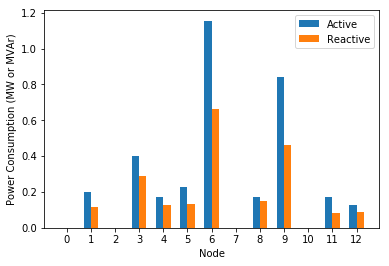

In [3]:
# Plot active and reactive power consumption
plt.figure(num=1, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
 
# create plot
fig, ax = plt.subplots()
width=0.3
ax.bar(j_idx-width/2,l_P,width,label='Active')
ax.bar(j_idx+width/2,l_Q,width,label='Reactive')
ax.set_xticks(j_idx)
ax.set_xlabel('Node')
ax.set_ylabel('Power Consumption (MW or MVAr)')
ax.legend()
plt.show()

## Problem 2

In [4]:
# Assumptions:
#   - Disregard the entire network diagram
#   - Balance supply and demand, without any network considerations
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)

# Define objective function
objective = Minimize( c*s )

# Define constraints
# Apparent Power Limits
constraints = [ s <= s_max ]

# Balance power generation with power consumption
constraints += [ sum_entries(p) == sum_entries(l_P), 
                 sum_entries(q) == sum_entries(l_Q)  ]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation
    constraints += [p[jj]>=0, 
                    q[jj]>=0]

    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(vstack(p[jj], q[jj]))]

# Define problem and solve
prob2 = Problem(objective, constraints)
prob2.solve()

# Output Results
print "------------------- PROBLEM 2 --------------------"
print "--------------------------------------------------"
print prob2.status
print "Minimum Generating Cost : %4.2f"%(prob2.value),"USD"
print " "
print "Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW"
print "Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW"
print "Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW"
print " "
print "Total active power   : %1.3f"%(sum(l_P)),"MW   consumed | %1.3f"%(sum(p.value)),"MW   generated"
print "Total reactive power : %1.3f"%(sum(l_Q)),"MVAr consumed | %1.3f"%(sum(q.value)),"MVAr generated"
print "Total apparent power : %1.3f"%(sum(l_S)),"MVA  consumed | %1.3f"%(sum(s.value)),"MVA  generated"

------------------- PROBLEM 2 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW
Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated


## Problem 3

In [5]:
# Assumptions:
#   - Disregard L_ij, the squared magnitude of complex line current
#   - Disregard nodal voltage equation
#   - Disregard nodal voltage limits
#   - Disregard maximum line current
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable(13,13)
Q = Variable(13,13)

# Define objective function
objective = Minimize( c*s )

# Define constraints
# Apparent Power Limits
constraints = [ s <= s_max ]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
               Q[0,0] == 0]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [ P[rho[jj],jj] == (l_P[jj] - p[jj]) + (A[jj,:]*P[jj,:].T), 
                     Q[rho[jj],jj] == (l_Q[jj] - q[jj]) + (A[jj,:]*Q[jj,:].T) ]

    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(vstack(p[jj], q[jj]),2)]
    
    ## pulled from p2 without skeleton code prompts
    # Non-negative power generation
    constraints += [p[jj]>=0, 
                    q[jj]>=0]

# Define problem and solve
prob3 = Problem(objective, constraints)
prob3.solve()

# Output Results
print "------------------- PROBLEM 3 --------------------"
print "--------------------------------------------------"
print prob3.status
print "Minimum Generating Cost : %4.2f"%(prob3.value),"USD"
print " "
print "Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW"
print "Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW"
print "Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW"
print " "
print "Total active power   : %1.3f"%(sum(l_P)),"MW   consumed | %1.3f"%(sum(p.value)),"MW   generated"
print "Total reactive power : %1.3f"%(sum(l_Q)),"MVAr consumed | %1.3f"%(sum(q.value)),"MVAr generated"
print "Total apparent power : %1.3f"%(sum(l_S)),"MVA  consumed | %1.3f"%(sum(s.value)),"MVA  generated"

------------------- PROBLEM 3 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW || mu_s9 =  50 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated


In [6]:
for con in constraints:
    print con
    print con.dual_value
    print " "

var142 <= [[5.]
 [0.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]]
[[2.71758165e-09]
 [3.05382314e+02]
 [3.05382314e+02]
 [2.70377377e-09]
 [3.05382314e+02]
 [3.05382314e+02]
 [3.05382315e+02]
 [3.05382314e+02]
 [3.05382315e+02]
 [5.00000000e+01]
 [3.05382314e+02]
 [3.05382314e+02]
 [3.05382314e+02]]
 
var143[0, 0] == 0
0.0
 
var144[0, 0] == 0
0.0
 
var143[0, 0] == 0.0 + -var140[0, 0] + [[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]].T * var143[0, :].T
-85.50449317301059
 
var144[0, 0] == 0.0 + -var141[0, 0] + [[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]].T * var144[0, :].T
-51.855391618224516
 
pnorm(vstack(var140[0, 0], var141[0, 0]), 2) <= var142[0, 0]
100.0000000027173
 
0 <= var140[0, 0]
9.812410228026723e-09
 
0 <= var141[0, 0]
5.643187855659141e-08
 
var143[0, 1] == 0.2 + -var140[1, 0] + [[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]].T * var143[1, :].T
-85.504493

## Problem 4

In [7]:
# Assumptions:
#   - Add back all previously disregarded terms and constraints
#   - Relax squared line current equation into inequality
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable(13,13)
Q = Variable(13,13)
V = Variable(13)
L = Variable(13,13)

# Define objective function
objective = Minimize( c*s )

# Define constraints
# Apparent Power Limits
constraints = [ s <= s_max ]

# Nodal voltage limits
constraints += [ v_min**2 <= V,
                 V <= v_max**2 ]

# Squared line current limits
constraints += [ L <= power(I_max,2) ]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [ P[i,jj] == (l_P[jj] - p[jj]) + r[i,jj]*L[i,jj] + (A[jj,:]*P[jj,:].T), 
                     Q[i,jj] == (l_Q[jj] - q[jj]) + x[i,jj]*L[i,jj] + (A[jj,:]*Q[jj,:].T) ]

    # Nodal voltage
    constraints += [ V[jj] == V[i] + (r[i,jj]**2 + x[i,jj]**2)*L[i,jj] - 2*(r[i,jj]*P[i,jj] + x[i,jj]*Q[i,jj]) ]
    
    # Squared current magnitude on lines
    constraints += [ L[i,jj] >= quad_over_lin( hstack(P[i,jj],Q[i,jj]), V[jj] ) ]
    
    # Compute apparent power from active & reactive power
    constraints += [ s[jj] >= norm(vstack(p[jj], q[jj])) ]
    
    ## the following constraints are pulled from p2 without skeleton code prompts
    # Non-negative power generation
    constraints += [p[jj]>=0, 
                    q[jj]>=0]   

# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print "------------------- PROBLEM 4 --------------------"
print "--------------------------------------------------"
print prob4.status
print "Minimum Generating Cost : %4.2f"%(prob4.value),"USD"
print " "
print "Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW"
print "Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW"
print "Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW"
print " "
print "Total active power   : %1.3f"%(sum(l_P)),"MW   consumed | %1.3f"%(sum(p.value)),"MW   generated"
print "Total reactive power : %1.3f"%(sum(l_Q)),"MVAr consumed | %1.3f"%(sum(q.value)),"MVAr generated"
print "Total apparent power : %1.3f"%(sum(l_S)),"MVA  consumed | %1.3f"%(sum(s.value)),"MVA  generated"
print " "
for jj in j_idx:
    print "Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u."

------------------- PROBLEM 4 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 299.69 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.568 MW | q_0 = 0.985 MW | s_0 = 1.852 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.941 MW | q_9 = 1.216 MW | s_9 = 2.290 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.509 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.201 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.142 MVA  generated
 
Node  0 Voltage : 1.000 p.u.
Node  1 Voltage : 0.967 p.u.
Node  2 Voltage : 0.963 p.u.
Node  3 Voltage : 0.963 p.u.
Node  4 Voltage : 0.962 p.u.
Node  5 Voltage : 0.960 p.u.
Node  6 Voltage : 0.957 p.u.
Node  7 Voltage : 0.957 p.u.
Node  8 Voltage : 0.957 p.u.
Node  9 Voltage : 0.964 p.u.
Node 10 Voltage : 0.955 p.u.
Node 11 Voltage : 0.954 p.u.
Node 12

In [8]:
for con in constraints:
    print con
    print con.dual_value
    print " "

var336 <= [[5.]
 [0.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]]
[[1.08210543e-09]
 [1.94494298e+02]
 [1.95197477e+02]
 [1.13999727e-09]
 [1.96537534e+02]
 [1.97468843e+02]
 [1.97999443e+02]
 [1.97899423e+02]
 [1.97809730e+02]
 [4.79610348e-09]
 [2.00345020e+02]
 [2.01119620e+02]
 [2.01063832e+02]]
 
0.9025 <= var339
[[3.47101627e-08]
 [1.04421705e-07]
 [1.33409699e-07]
 [1.33410432e-07]
 [1.48706832e-07]
 [1.72922425e-07]
 [2.44481297e-07]
 [2.44483372e-07]
 [2.44482690e-07]
 [1.24619479e-07]
 [3.49212298e-07]
 [4.55897660e-07]
 [5.89494942e-07]]
 
var339 <= 1.1025
[[3.30202906e-08]
 [2.02681116e-08]
 [1.94660106e-08]
 [1.94659757e-08]
 [1.91775306e-08]
 [1.88432146e-08]
 [1.82949162e-08]
 [1.82963220e-08]
 [1.82948254e-08]
 [1.96894994e-08]
 [1.79090210e-08]
 [1.77071920e-08]
 [1.75632707e-08]]
 
var340 <= power([[0.      3.0441  0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]
 [0.      0.      1.4178  0.      0.9591  0.  

In [9]:
# (f) redo with tigher voltage bounds

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable(13,13)
Q = Variable(13,13)
V = Variable(13)
L = Variable(13,13)

# Define objective function
objective = Minimize( c*s )

# Define constraints
# Apparent Power Limits
constraints = [ s <= s_max ]

# Nodal voltage limits
constraints += [ 0.98**2 <= V,
                 V <= 1.02**2 ]

# Squared line current limits
constraints += [ L <= power(I_max,2) ]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [ P[i,jj] == (l_P[jj] - p[jj]) + r[i,jj]*L[i,jj] + (A[jj,:]*P[jj,:].T), 
                     Q[i,jj] == (l_Q[jj] - q[jj]) + x[i,jj]*L[i,jj] + (A[jj,:]*Q[jj,:].T) ]

    # Nodal voltage
    constraints += [ V[jj] == V[i] + (r[i,jj]**2 + x[i,jj]**2)*L[i,jj] - 2*(r[i,jj]*P[i,jj] + x[i,jj]*Q[i,jj]) ]
    
    # Squared current magnitude on lines
    constraints += [ L[i,jj] >= quad_over_lin( hstack(P[i,jj],Q[i,jj]), V[jj] ) ]
    
    # Compute apparent power from active & reactive power
    constraints += [ s[jj] >= norm(vstack(p[jj], q[jj])) ]
    
    ## the following constraints are pulled from p2 without skeleton code prompts
    # Non-negative power generation
    constraints += [p[jj]>=0, 
                    q[jj]>=0]   

# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print "------------------- PROBLEM 4f --------------------"
print "---------------------------------------------------"
print prob4.status
print "Minimum Generating Cost : %4.2f"%(prob4.value),"USD"
print " "
print "Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW"
print "Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW"
print "Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW"
print " "
print "Total active power   : %1.3f"%(sum(l_P)),"MW   consumed | %1.3f"%(sum(p.value)),"MW   generated"
print "Total reactive power : %1.3f"%(sum(l_Q)),"MVAr consumed | %1.3f"%(sum(q.value)),"MVAr generated"
print "Total apparent power : %1.3f"%(sum(l_S)),"MVA  consumed | %1.3f"%(sum(s.value)),"MVA  generated"
print " "
for jj in j_idx:
    print "Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u."

------------------- PROBLEM 4f --------------------
---------------------------------------------------
optimal
Minimum Generating Cost : 348.67 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.940 MW | q_0 = 0.174 MW | s_0 = 0.956 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.760 MW | q_3 = 0.518 MW | s_3 = 0.920 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.789 MW | q_9 = 1.450 MW | s_9 = 2.303 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.489 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.142 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.178 MVA  generated
 
Node  0 Voltage : 1.000 p.u.
Node  1 Voltage : 0.989 p.u.
Node  2 Voltage : 0.992 p.u.
Node  3 Voltage : 0.992 p.u.
Node  4 Voltage : 0.984 p.u.
Node  5 Voltage : 0.983 p.u.
Node  6 Voltage : 0.984 p.u.
Node  7 Voltage : 0.984 p.u.
Node  8 Voltage : 0.984 p.u.
Node  9 Voltage : 0.991 p.u.
Node 10 Voltage : 0.982 p.u.
Node 11 Voltage : 0.981 p.u.
Node 

In [10]:
for con in constraints:
    print con
    print con.dual_value
    print " "

var672 <= [[5.]
 [0.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]]
[[1.80489106e-09]
 [2.66463673e+02]
 [2.65707635e+02]
 [3.14946670e-09]
 [2.69430295e+02]
 [2.70720492e+02]
 [3.19685062e+02]
 [3.19556177e+02]
 [3.19783623e+02]
 [8.78538903e-09]
 [3.37127036e+02]
 [3.38223902e+02]
 [3.65409843e+02]]
 
0.9604 <= var675
[[1.31943959e-07]
 [2.66099202e-07]
 [2.07217036e-07]
 [2.07262166e-07]
 [4.78789809e-07]
 [5.28950896e-07]
 [5.63980239e-07]
 [5.64851942e-07]
 [5.63723595e-07]
 [2.37601028e-07]
 [8.59004030e-07]
 [4.43805695e-07]
 [1.37052896e+03]]
 
var675 <= 1.0404
[[1.29329721e-07]
 [8.75873415e-08]
 [9.79887287e-08]
 [9.79880553e-08]
 [7.59696303e-08]
 [7.27805505e-08]
 [7.54332784e-08]
 [7.54951419e-08]
 [7.54308621e-08]
 [9.23137685e-08]
 [7.16737690e-08]
 [6.97622324e-08]
 [6.83976281e-08]]
 
var676 <= power([[0.      3.0441  0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]
 [0.      0.      1.4178  0.      0.9591  0.  

## Problem 5

In [11]:
# Assumptions:
#   - Assume solar generator at node 9 has uncertain power capacity
#   - Goal is to minimize generation costs, given by c^T s, in face of uncertainty

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable(13,13)
Q = Variable(13,13)
V = Variable(13)
L = Variable(13,13)
sigma = Variable(2,1)

# Define objective function
objective = Minimize( c*s )

# Define constraints
# Apparent Power Limits
constraints = [ s <= s_max ]

# Nodal voltage limits
constraints += [ v_min**2 <= V,
                 V <= v_max**2 ]

# Squared line current limits
constraints += [ L <= power(I_max,2) ]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [ P[i,jj] == (l_P[jj] - p[jj]) + r[i,jj]*L[i,jj] + (A[jj,:]*P[jj,:].T), 
                     Q[i,jj] == (l_Q[jj] - q[jj]) + x[i,jj]*L[i,jj] + (A[jj,:]*Q[jj,:].T) ]

    # Nodal voltage
    constraints += [ V[jj] == V[i] + (r[i,jj]**2 + x[i,jj]**2)*L[i,jj] - 2*(r[i,jj]*P[i,jj] + x[i,jj]*Q[i,jj]) ]
    
    # Squared current magnitude on lines
    constraints += [ L[i,jj] >= quad_over_lin( hstack(P[i,jj],Q[i,jj]), V[jj] ) ]
    
    # Compute apparent power from active & reactive power
    constraints += [ s[jj] >= norm(vstack(p[jj], q[jj])) ]
    
    ## the following constraints are pulled from p2 without skeleton code prompts
    # Non-negative power generation
    constraints += [p[jj]>=0, 
                    q[jj]>=0]   

# SOCP robust constraint
abar = np.array([ 1, -1.25, -1.25 ])
y = vstack(s[9],sigma)
E = np.array([[0, 0,    0],
              [0, 0.25, 0],
              [0, 0, 0.25]])
constraints += [ abar*y + norm( E.T*y ) <= 0 ]

# sigma bounds
constraints += [ sigma >= 0,
                 sigma <= 1 ]
    
# Define problem and solve
prob5 = Problem(objective, constraints)
prob5.solve()

# Output Results
print "------------------- PROBLEM 5 --------------------"
print "--------------------------------------------------"
print prob5.status
print "Minimum Generating Cost : %4.2f"%(prob5.value),"USD"
print " "
print "Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW"
print "Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW"
print "Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW"
print " "
print "Total active power   : %1.3f"%(sum(l_P)),"MW   consumed | %1.3f"%(sum(p.value)),"MW   generated"
print "Total reactive power : %1.3f"%(sum(l_Q)),"MVAr consumed | %1.3f"%(sum(q.value)),"MVAr generated"
print "Total apparent power : %1.3f"%(sum(l_S)),"MVA  consumed | %1.3f"%(sum(s.value)),"MVA  generated"

------------------- PROBLEM 5 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 308.72 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.745 MW | q_0 = 1.006 MW | s_0 = 2.014 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = -0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.770 MW | q_9 = 1.215 MW | s_9 = 2.146 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.514 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.221 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.160 MVA  generated
